In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
%%R
library(edgeR)

Loading required package: limma


In [3]:
adata_pb = sc.read('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/pb_adata_MG_sep.h5ad')
adata_pb

AnnData object with n_obs × n_vars = 292 × 29040
    obs: 'sample', 'sample_lesion', 'diagnosis', 'sample_source', 'cell_type', 'sample_rep', 'replicate_cat', 'stim', 'sex', 'seq_pool', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'batch', 'lib_size', 'log_lib_size'
    uns: 'age_cat_colors', 'cell_type_colors', 'diagnosis_colors', 'log1p', 'pca', 'pmi_cat2_colors', 'pmi_cat_colors', 'sample_source_colors', 'seq_pool_colors', 'sex_colors', 'stim_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

# Identify outliers

In [4]:
adata_pb.obs['cell_stim'] = adata_pb.obs['cell_type'].astype(str) + '_' + adata_pb.obs['stim'].astype(str)

In [5]:
# Extract the log_lib_size column
log_lib_size = adata_pb.obs['log_lib_size']

# Compute the median
median = np.median(log_lib_size)

# Compute the MAD (Median Absolute Deviation)
mad = np.median(np.abs(log_lib_size - median))

# Define the upper and lower thresholds
upper_threshold = median + 3 * mad
lower_threshold = median - 3 * mad

# Find outliers
outliers = adata_pb.obs[(log_lib_size < lower_threshold)]

# Print the results
print(f"Median: {median}, MAD: {mad}")
print(f"Lower threshold: {lower_threshold}")
print(f"Outliers:\n{outliers}")

Median: 12.186070736808462, MAD: 0.8403393485043571
Lower threshold: 9.66505269129539
Outliers:
                                            sample       sample_lesion  \
donor_Ind120-Sample1_0-0-0-0-0-0-0  Ind120-Sample1  Ind120-Sample1_CAL   
donor_Ind143-Sample1_0-1-0-0        Ind143-Sample1   Ind143-Sample1_AL   

                                   diagnosis sample_source cell_type  \
donor_Ind120-Sample1_0-0-0-0-0-0-0      SPMS  Amsterdam BB      Mg_A   
donor_Ind143-Sample1_0-1-0-0            PPMS  Amsterdam BB      Mg_E   

                                   sample_rep replicate_cat stim sex seq_pool  \
donor_Ind120-Sample1_0-0-0-0-0-0-0      CAL_5             5  CAL   M   Pool 1   
donor_Ind143-Sample1_0-1-0-0            AL_20            20   AL   M   Pool 1   

                                   age_scale   age_cat    pmi_cat   pmi_cat2  \
donor_Ind120-Sample1_0-0-0-0-0-0-0  0.713744   over_70  6H_to_12H  up_to_12H   
donor_Ind143-Sample1_0-1-0-0       -1.141343  under_50  6H_t

In [6]:
# Compute the max and min log_lib_size
max_log_lib_size = log_lib_size.max()
min_log_lib_size = log_lib_size.min()

print(f"Maximum log_lib_size: {max_log_lib_size}")
print(f"Minimum log_lib_size: {min_log_lib_size}")

Maximum log_lib_size: 15.242901515897758
Minimum log_lib_size: 9.490620114661201


In [7]:
print(f"All samples: {adata_pb.shape[0]}")

All samples: 292


In [8]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim       AL  CAL  CIL  NAWM  RL  WM
cell_type                            
Mg_A       13    7    5     8   5   9
Mg_B       12    7   10    12   9  11
Mg_C       13   11    8     9   7   6
Mg_D       11    7    4     7   3   0
Mg_E       14   13    8     7   4   2
Mg_F        6    7    5     7   5   4
Mg_G        5    3    2     2   4   0

In [9]:
# Define the list of samples to remove
samples_to_remove = [
    "donor_Ind120-Sample1_0-0-0-0-0-0-0",
    "donor_Ind143-Sample1_0-1-0-0"
]

# Filter out the samples to remove
adata_pb = adata_pb[~adata_pb.obs.index.isin(samples_to_remove)].copy()

# Confirm removal
print(f"Remaining samples: {adata_pb.shape[0]}")

Remaining samples: 290


# Subset to relevant comparison 

In [10]:
# Extract the data as a pandas DataFrame
df = adata_pb.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim       AL  CAL  CIL  NAWM  RL  WM
cell_type                            
Mg_A       13    6    5     8   5   9
Mg_B       12    7   10    12   9  11
Mg_C       13   11    8     9   7   6
Mg_D       11    7    4     7   3   0
Mg_E       13   13    8     7   4   2
Mg_F        6    7    5     7   5   4
Mg_G        5    3    2     2   4   0

In [20]:
adata_sub= adata_pb[np.in1d(adata_pb.obs['cell_type'], 
                           ['Mg_A', 'Mg_D'])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (78, 29040)


In [21]:
adata_sub.obs[:5]

sample       sample_lesion  \
donor_Ind98-Sample2_0-0-0-0-0-0-0    Ind98-Sample2    Ind98-Sample2_WM   
donor_Ind102-Sample1_0-0-0-0-0-0-0  Ind102-Sample1   Ind102-Sample1_AL   
donor_Ind102-Sample4_0-0-0-0-0-0-0  Ind102-Sample4  Ind102-Sample4_CAL   
donor_Ind103-Sample1_0-0-0-0-0-0-0  Ind103-Sample1   Ind103-Sample1_AL   
donor_Ind104-Sample1_0-0-0-0-0-0-0  Ind104-Sample1   Ind104-Sample1_RL   

                                   diagnosis sample_source cell_type  \
donor_Ind98-Sample2_0-0-0-0-0-0-0        CTR  Edinburgh BB      Mg_A   
donor_Ind102-Sample1_0-0-0-0-0-0-0      SPMS  Amsterdam BB      Mg_A   
donor_Ind102-Sample4_0-0-0-0-0-0-0      SPMS  Amsterdam BB      Mg_A   
donor_Ind103-Sample1_0-0-0-0-0-0-0      RRMS  Amsterdam BB      Mg_A   
donor_Ind104-Sample1_0-0-0-0-0-0-0      SPMS      UK MS TB      Mg_A   

                                   sample_rep replicate_cat stim sex seq_pool  \
donor_Ind98-Sample2_0-0-0-0-0-0-0        WM_1             1   WM   M   Pool 6   
donor_Ind102-Sample1_0-0-0-0-0-0-0       AL_1             1   AL   M   Pool 4   
donor_Ind102-Sample4_0-0-0-0-0-0-0     CAL_17            17  CAL   M   Pool 1   
donor_Ind103-Sample1_0-0-0-0-0-0-0       AL_2             2   AL   F   Pool 3   
donor_Ind104-Sample1_0-0-0-0-0-0-0       RL_2             2   RL   F   Pool 5   

                                   age_scale    age_cat    pmi_cat   pmi_cat2  \
donor_Ind98-Sample2_0-0-0-0-0-0-0  -1.759706   under_50   over_12H   over_12H   
donor_Ind102-Sample1_0-0-0-0-0-0-0  0.301502  inbetween  6H_to_12H  up_to_12H   
donor_Ind102-Sample4_0-0-0-0-0-0-0  0.301502  inbetween  6H_to_12H  up_to_12H   
donor_Ind103-Sample1_0-0-0-0-0-0-0 -1.484878   under_50   up_to_6H  up_to_12H   
donor_Ind104-Sample1_0-0-0-0-0-0-0  0.645037  inbetween   over_12H   over_12H   

                                   batch  lib_size  log_lib_size cell_stim  
donor_Ind98-Sample2_0-0-0-0-0-0-0      0    268489     12.500565   Mg_A_WM  
donor_Ind102-Sample1_0-0-0-0-0-0-0     0     66310     11.102096   Mg_A_AL  
donor_Ind102-Sample4_0-0-0-0-0-0-0     0     40936     10.619765  Mg_A_CAL  
donor_Ind103-Sample1_0-0-0-0-0-0-0     0    143763     11.875921   Mg_A_AL  
donor_Ind104-Sample1_0-0-0-0-0-0-0     0     35938     10.489551   Mg_A_RL

In [22]:
# Unique values in the 'condition' column
unique_conditions = adata_sub.obs['stim'].unique()
for condition in unique_conditions:
    print(condition)

WM
AL
CAL
RL
CIL
NAWM


In [23]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['stim'], 
                           ['WM',
                              'AL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (33, 29040)


In [24]:
# Check if the 'sample_rep' column exists
if 'sample_lesion' in adata_sub.obs.columns:
    # Set the 'sample_rep' column as the index
    adata_sub.obs.set_index('sample_lesion', inplace=True)
else:
    print("The column 'sample' does not exist in adata_sub.obs.")

adata_sub.obs.index.name = None

In [25]:
# Add the index back as a column called 'sample_lesion'
adata_sub.obs['sample_lesion'] = adata_sub.obs.index

In [26]:
adata_sub.obs['indiv_id'] = adata_sub.obs['sample'].str.split('-').str[0]
adata_sub.obs[:5]

sample diagnosis sample_source cell_type  \
Ind98-Sample2_WM    Ind98-Sample2       CTR  Edinburgh BB      Mg_A   
Ind102-Sample1_AL  Ind102-Sample1      SPMS  Amsterdam BB      Mg_A   
Ind103-Sample1_AL  Ind103-Sample1      RRMS  Amsterdam BB      Mg_A   
Ind107-Sample1_WM  Ind107-Sample1       CTR  Edinburgh BB      Mg_A   
Ind113-Sample1_AL  Ind113-Sample1      SPMS  Amsterdam BB      Mg_A   

                  sample_rep replicate_cat stim sex seq_pool age_scale  \
Ind98-Sample2_WM        WM_1             1   WM   M   Pool 6 -1.759706   
Ind102-Sample1_AL       AL_1             1   AL   M   Pool 4  0.301502   
Ind103-Sample1_AL       AL_2             2   AL   F   Pool 3 -1.484878   
Ind107-Sample1_WM       WM_3             3   WM   M   Pool 3 -0.935223   
Ind113-Sample1_AL       AL_6             6   AL   F   Pool 4  1.125985   

                     age_cat    pmi_cat   pmi_cat2 batch  lib_size  \
Ind98-Sample2_WM    under_50   over_12H   over_12H     0    268489   
Ind102-Sample1_AL  inbetween  6H_to_12H  up_to_12H     0     66310   
Ind103-Sample1_AL   under_50   up_to_6H  up_to_12H     0    143763   
Ind107-Sample1_WM   under_50   over_12H   over_12H     0    706855   
Ind113-Sample1_AL    over_70   up_to_6H  up_to_12H     0     72946   

                   log_lib_size cell_stim      sample_lesion indiv_id  
Ind98-Sample2_WM      12.500565   Mg_A_WM   Ind98-Sample2_WM    Ind98  
Ind102-Sample1_AL     11.102096   Mg_A_AL  Ind102-Sample1_AL   Ind102  
Ind103-Sample1_AL     11.875921   Mg_A_AL  Ind103-Sample1_AL   Ind103  
Ind107-Sample1_WM     13.468581   Mg_A_WM  Ind107-Sample1_WM   Ind107  
Ind113-Sample1_AL     11.197475   Mg_A_AL  Ind113-Sample1_AL   Ind113

In [27]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_stim', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_stim', 'stim']).size().unstack(fill_value=0)
summary_table

stim       AL  WM
cell_stim        
Mg_A_AL    13   0
Mg_A_WM     0   9
Mg_D_AL    11   0

In [28]:
adata_sub= adata_sub[np.in1d(adata_sub.obs['cell_stim'], 
                           ['Mg_A_WM',
                            'Mg_D_AL'
                           ])].copy()

print("Dimensions of adata_sub:", adata_sub.shape)

Dimensions of adata_sub: (20, 29040)


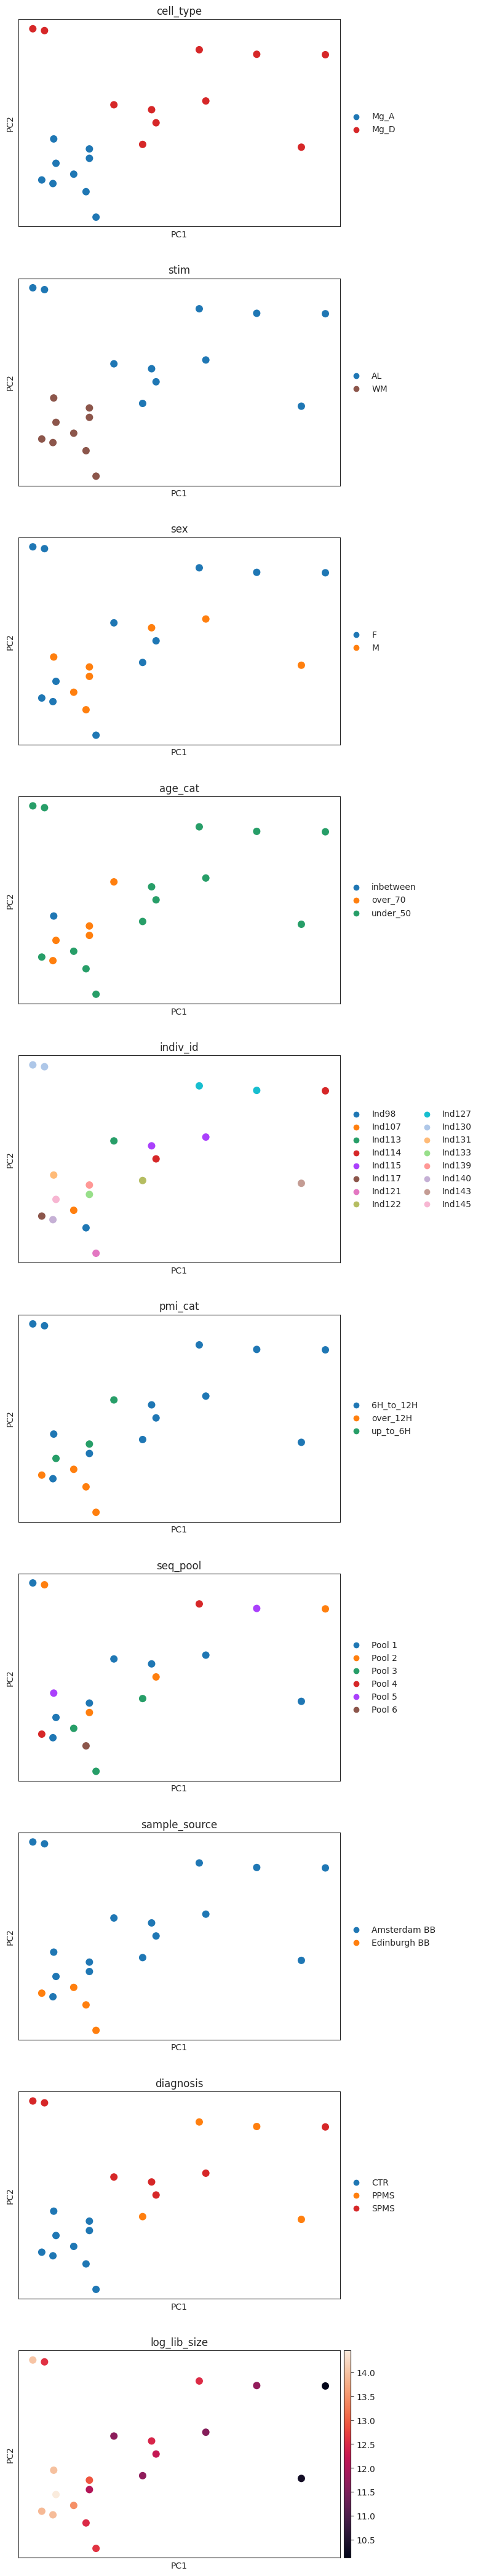

In [29]:
sc.pl.pca(adata_sub, color=["cell_type", "stim", "sex", "age_cat", "indiv_id",
                            "pmi_cat", "seq_pool", "sample_source", "diagnosis", "log_lib_size"], 
          ncols=1, size=300)

In [30]:
# Replace space with underscore in the 'seq_pool' column
adata_sub.obs['seq_pool'] = adata_sub.obs['seq_pool'].str.replace(' ', '_')
adata_sub.obs[:5]

sample diagnosis sample_source cell_type  \
Ind98-Sample2_WM    Ind98-Sample2       CTR  Edinburgh BB      Mg_A   
Ind107-Sample1_WM  Ind107-Sample1       CTR  Edinburgh BB      Mg_A   
Ind117-Sample1_WM  Ind117-Sample1       CTR  Edinburgh BB      Mg_A   
Ind121-Sample1_WM  Ind121-Sample1       CTR  Edinburgh BB      Mg_A   
Ind131-Sample1_WM  Ind131-Sample1       CTR  Amsterdam BB      Mg_A   

                  sample_rep replicate_cat stim sex seq_pool age_scale  \
Ind98-Sample2_WM        WM_1             1   WM   M   Pool_6 -1.759706   
Ind107-Sample1_WM       WM_3             3   WM   M   Pool_3 -0.935223   
Ind117-Sample1_WM       WM_4             4   WM   F   Pool_4 -0.935223   
Ind121-Sample1_WM       WM_5             5   WM   F   Pool_3 -0.729102   
Ind131-Sample1_WM       WM_7             7   WM   M   Pool_5  0.438916   

                     age_cat    pmi_cat   pmi_cat2 batch  lib_size  \
Ind98-Sample2_WM    under_50   over_12H   over_12H     0    268489   
Ind107-Sample1_WM   under_50   over_12H   over_12H     0    706855   
Ind117-Sample1_WM   under_50   over_12H   over_12H     0   1079993   
Ind121-Sample1_WM   under_50   over_12H   over_12H     0    297926   
Ind131-Sample1_WM  inbetween  6H_to_12H  up_to_12H     0   1178400   

                   log_lib_size cell_stim      sample_lesion indiv_id  
Ind98-Sample2_WM      12.500565   Mg_A_WM   Ind98-Sample2_WM    Ind98  
Ind107-Sample1_WM     13.468581   Mg_A_WM  Ind107-Sample1_WM   Ind107  
Ind117-Sample1_WM     13.892465   Mg_A_WM  Ind117-Sample1_WM   Ind117  
Ind121-Sample1_WM     12.604600   Mg_A_WM  Ind121-Sample1_WM   Ind121  
Ind131-Sample1_WM     13.979668   Mg_A_WM  Ind131-Sample1_WM   Ind131

In [31]:
#Check the counts data
print(adata_sub.X[:5, :5])

[[ 2  1  0  0  6]
 [12  0  0  0 40]
 [ 7  0  0  0 41]
 [ 2  0  0  0 10]
 [ 4  0  1  0 23]]


In [32]:
# Extract the data as a pandas DataFrame
df = adata_sub.obs[['cell_type', 'stim']]

# Create a summary table
summary_table = df.groupby(['cell_type', 'stim']).size().unstack(fill_value=0)
summary_table

stim       AL  WM
cell_type        
Mg_A        0   9
Mg_D       11   0

# Start R code: QC of log transformation

In [33]:
for col in adata_sub.obs.columns:
    if pd.api.types.is_categorical_dtype(adata_sub.obs[col]):
        adata_sub.obs[col] = adata_sub.obs[col].astype(str)

In [34]:
%%R -i adata_sub

# Concatenate label and cell type for group factor
group <- colData(adata_sub)$stim #ctrl or stim
replicate <- colData(adata_sub)$replicate_cat #replicate number
batch <- colData(adata_sub)$sample_lesion #this is each indiv sample

# Concatenate label and cell type for group factor
sex <- colData(adata_sub)$sex #ctrl or stim
age_cat <- colData(adata_sub)$age_cat #replicate number
pmi_cat <- colData(adata_sub)$pmi_cat #this is each indiv sample
pmi_cat2 <- colData(adata_sub)$pmi_cat2 #replicate number
seq_pool <- colData(adata_sub)$seq_pool #this is each indiv sample

treatments <- data.frame("Group"=group, "Reps"=replicate, "Batch"=batch,
                        "Sex"=sex, "Age_cat"=age_cat, "Pmi_cat"=pmi_cat, "Pmi_cat2"=pmi_cat2,
                        "Seq_pool"=seq_pool)
head(treatments)

                  Group Reps             Batch Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM    1  Ind98-Sample2_WM   M  under_50  over_12H
Ind107-Sample1_WM    WM    3 Ind107-Sample1_WM   M  under_50  over_12H
Ind117-Sample1_WM    WM    4 Ind117-Sample1_WM   F  under_50  over_12H
Ind121-Sample1_WM    WM    5 Ind121-Sample1_WM   F  under_50  over_12H
Ind131-Sample1_WM    WM    7 Ind131-Sample1_WM   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM    8 Ind133-Sample1_WM   M   over_70 6H_to_12H
                   Pmi_cat2 Seq_pool
Ind98-Sample2_WM   over_12H   Pool_6
Ind107-Sample1_WM  over_12H   Pool_3
Ind117-Sample1_WM  over_12H   Pool_4
Ind121-Sample1_WM  over_12H   Pool_3
Ind131-Sample1_WM up_to_12H   Pool_5
Ind133-Sample1_WM up_to_12H   Pool_2


In [35]:
%%R -i adata_sub

# Create the treatments dataframe with samples as a column, not as row names
treatments <- data.frame(
  #Sample = colData(adata_sub)$sample,      # Sample column
  Group = colData(adata_sub)$stim,        # Group (e.g., ctrl or stim)
  Donor = colData(adata_sub)$indiv_id,    # Donor information
  Sex = colData(adata_sub)$sex,           # Sex information
  Age_cat = colData(adata_sub)$age_cat,   # Age category
  Pmi_cat = colData(adata_sub)$pmi_cat   # Post-mortem interval category
)

# Check the updated dataframe to confirm
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind131-Sample1_WM    WM Ind131   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM Ind133   M   over_70 6H_to_12H


In [36]:
%%R

#Create a DGElist object using the anndata counts in 'X'
x <- DGEList(assay(adata_sub, "X"), group=colData(adata_sub)$stim)

samplenames <- colnames(x$counts)

print("Dimensions before subsetting:")
print(dim(x))

# Check counts per group before filtering
print(table(x$samples$group))

[1] "Dimensions before subsetting:"
[1] 29040    20

AL WM 
11  9 


In [37]:
%%R

# Adjust for batch-- ie publication in the model matrix
design_full <- model.matrix(~0 + Group + Sex + Age_cat + Pmi_cat, data=treatments)
rownames(design_full) <- colnames(x)
colnames(design_full)

[1] "GroupAL"         "GroupWM"         "SexM"            "Age_catover_70" 
[5] "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [38]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.expr <- filterByExpr(x, design_full)
x2 <- x[keep.expr,, keep.lib.sizes=FALSE]
dim(x2)

[1] 9040   20


In [39]:
%%R

# More strict removal of genes, tried group, pub and batch
keep.exprs <- filterByExpr(x, group=batch)
b <- x[keep.exprs,, keep.lib.sizes=FALSE]
dim(b)

[1] 9040   20


In [40]:
%%R
## Calc norm factors before to normalize library sizes, then cpm divides counts by lib sizes
#X is before trimming, Y is after trimming, X2 is also trimmed but differently
x2 <- calcNormFactors(x2, method = "TMM")
x2$samples$norm.factors

 [1] 0.9978151 0.9840573 1.0221445 1.0277037 0.9780239 1.0148235 0.9951507
 [8] 1.0352885 0.9877805 1.0576309 0.8954290 1.3669821 0.9784155 0.8926107
[15] 1.0660446 0.8030423 0.8566060 0.9437018 0.9916881 1.2370300


In [41]:
%%R
cd <- x2$samples$group
print(cd)

 [1] WM WM WM WM WM WM WM WM WM AL AL AL AL AL AL AL AL AL AL AL
Levels: AL WM


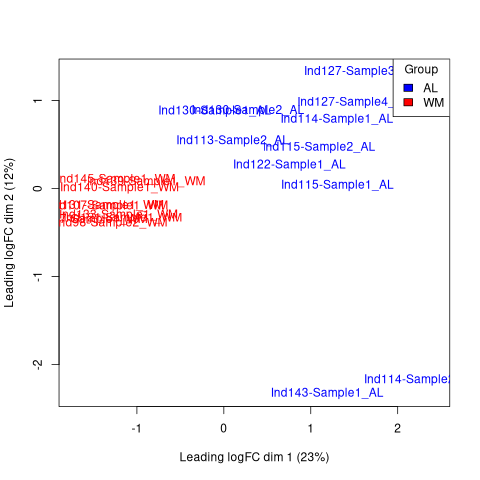

In [42]:
%%R
# Assuming 'group' is stored in y$samples dataframe
group <- x2$samples$group

# Generate a numeric vector from group factors (if not already factor, convert it)
group_factor <- as.factor(group)
group_colors <- as.numeric(group_factor)  # This converts factors to unique integers

# Define a set of colors corresponding to the factors
# Example: If you have two groups, you could define two colors
colors <- c("blue", "red")  # Adjust the number and colors based on your actual groups

# Use these colors in your plotMDS
plotMDS(x2, col = colors[group_colors])

# Adding a legend for clarity
legend("topright", legend=levels(group_factor), fill=colors, title="Group")

# Voom with quality weights- sex, age, pmi, seq_pool

In [43]:
%%R
donor <- colData(adata_sub)$indiv_id #this is each indiv sample
donor

 Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM Ind121-Sample1_WM 
          "Ind98"          "Ind107"          "Ind117"          "Ind121" 
Ind131-Sample1_WM Ind133-Sample1_WM Ind139-Sample1_WM Ind140-Sample1_WM 
         "Ind131"          "Ind133"          "Ind139"          "Ind140" 
Ind145-Sample1_WM Ind113-Sample2_AL Ind114-Sample1_AL Ind114-Sample2_AL 
         "Ind145"          "Ind113"          "Ind114"          "Ind114" 
Ind115-Sample1_AL Ind115-Sample2_AL Ind122-Sample1_AL Ind127-Sample3_AL 
         "Ind115"          "Ind115"          "Ind122"          "Ind127" 
Ind127-Sample4_AL Ind130-Sample1_AL Ind130-Sample2_AL Ind143-Sample1_AL 
         "Ind127"          "Ind130"          "Ind130"          "Ind143" 


In [44]:
%%R
head(design_full)

                  GroupAL GroupWM SexM Age_catover_70 Age_catunder_50
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind131-Sample1_WM       0       1    1              0               0
Ind133-Sample1_WM       0       1    1              1               0
                  Pmi_catover_12H Pmi_catup_to_6H
Ind98-Sample2_WM                1               0
Ind107-Sample1_WM               1               0
Ind117-Sample1_WM               1               0
Ind121-Sample1_WM               1               0
Ind131-Sample1_WM               0               0
Ind133-Sample1_WM               0               0


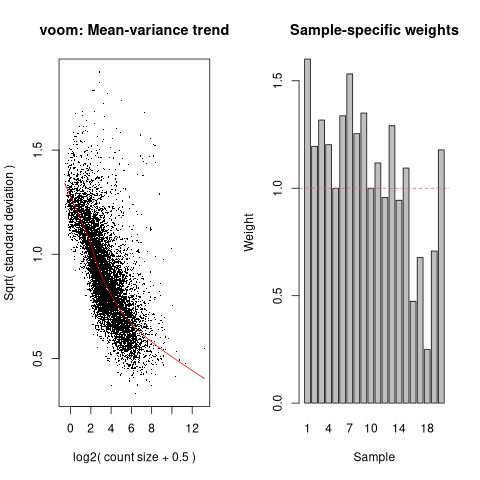

In [45]:
%%R

y_vqw_full <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE)

In [46]:
%%R

corfit <- duplicateCorrelation(y_vqw_full, design_full, block=donor)
corfit$consensus.correlation

[1] 0.4363248


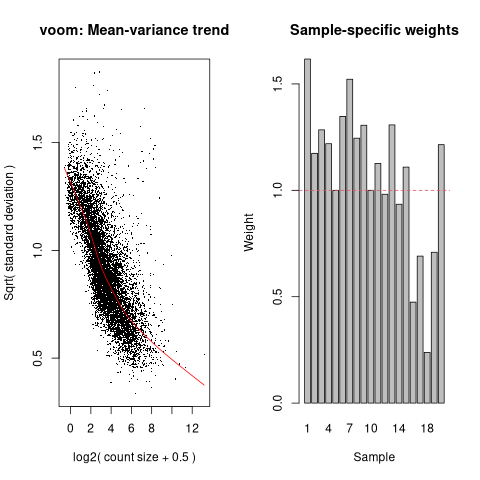

In [47]:
%%R

y2 <- voomWithQualityWeights(x2$counts, design_full, plot=TRUE, block=donor, correlation=corfit$consensus)

In [48]:
%%R

corfit2 <- duplicateCorrelation(y2, design_full, block=donor)
corfit2$consensus.correlation

[1] 0.4356351


In [49]:
%%R

fit <- lmFit(y2, design_full, block=donor, correlation=corfit2$consensus)

In [51]:
%%R

contr <- makeContrasts(GroupAL - GroupWM, levels = colnames(coef(fit)))

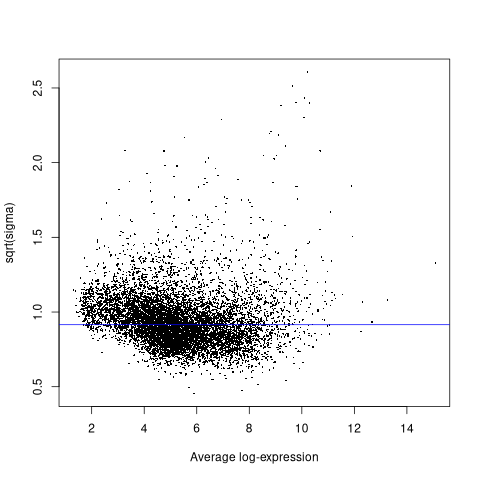

In [52]:
%%R

tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [53]:
%%R

# Retrieve the top results without sorting by p-value directly
tt <- topTable(tmp2, sort.by = "P", n = Inf)
head(tt, 10)

             logFC   AveExpr        t      P.Value   adj.P.Val        B
SPP1      3.703706 11.931579 7.435137 2.991380e-07 0.001393525 6.853087
OVCH1-AS1 8.368035  2.091908 7.420403 3.083021e-07 0.001393525 4.796615
TMED10    2.359848  6.267430 6.271630 3.543289e-06 0.006880128 4.495188
MT-ND6    8.061624  3.153314 6.249196 3.722678e-06 0.006880128 2.720226
SIRPA     1.867937  7.746213 6.195246 4.193228e-06 0.006880128 4.409018
LILRB3    6.138368  3.907913 6.156699 4.566457e-06 0.006880128 2.993237
MYO1E     3.355918  9.429125 5.706645 1.252000e-05 0.016168692 3.374594
FTL       2.300459  9.066997 5.528765 1.876973e-05 0.021209790 2.945141
GOLIM4    2.189310  6.666445 5.385082 2.609400e-05 0.022061017 2.672002
CTSB      2.243880  9.365718 5.384405 2.613469e-05 0.022061017 2.593524


In [54]:
%%R
length(which(tt$adj.P.Val < 0.05))

[1] 24


In [55]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt[tt$adj.P.Val < 0.05 & tt$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 22
             logFC  AveExpr        t      P.Value   adj.P.Val        B
OVCH1-AS1 8.368035 2.091908 7.420403 3.083021e-07 0.001393525 4.796615
MT-ND6    8.061624 3.153314 6.249196 3.722678e-06 0.006880128 2.720226
LPL       7.669121 5.514094 4.980538 6.665326e-05 0.037659092 1.325831
LILRB3    6.138368 3.907913 6.156699 4.566457e-06 0.006880128 2.993237
MAFB      4.770516 6.334708 5.244467 3.609154e-05 0.025097502 2.225284
MFGE8     4.713592 3.497321 5.372763 2.684416e-05 0.022061017 2.265793


In [56]:
%%R

# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt[tt$adj.P.Val < 0.05 & tt$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 2
          logFC   AveExpr         t      P.Value  adj.P.Val        B
ABCC4 -1.816042  9.257282 -4.749653 1.144784e-04 0.04473221 1.239539
MBNL1 -1.168317 10.038260 -4.992283 6.485063e-05 0.03765909 1.718375


## Voom by group

Group:
1 AL 
2 WM 


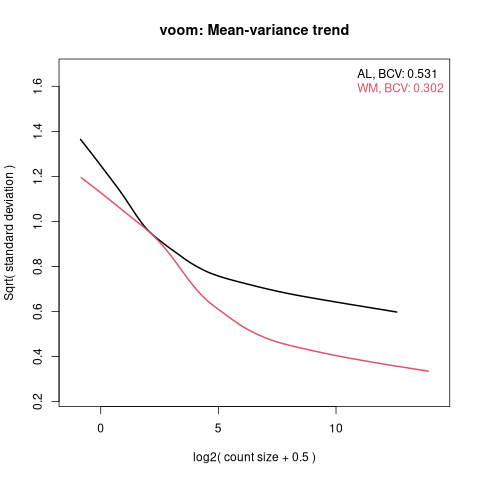

In [57]:
%%R
source("/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/MM_sysVI/voomByGroup.R")
y_vbg <- voomByGroup(x2,design = design_full, group = cd, plot = "combine")

In [58]:
%%R
fit <- lmFit(y_vbg, design_full)

In [60]:
%%R
contr <- makeContrasts(GroupAL - GroupWM, levels = colnames(coef(fit)))

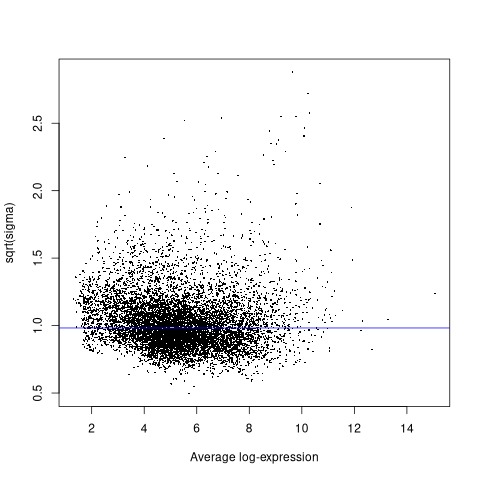

In [61]:
%%R
tmp <- contrasts.fit(fit, contr)
tmp2 <- eBayes(tmp)
tt_full <- topTable(tmp2, sort.by = "P", n = Inf)

plotSA(tmp2, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [62]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC > 1, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 8
             logFC   AveExpr        t      P.Value  adj.P.Val        B
OVCH1-AS1 8.515409  2.091909 7.318842 5.522046e-07 0.00499193 4.606395
MT-ND6    7.801905  3.153315 5.871927 1.101923e-05 0.02340957 2.234715
LPL       7.621562  5.514095 5.797489 1.294777e-05 0.02340957 2.600333
LILRB3    6.068560  3.907914 6.164705 5.881953e-06 0.01772429 2.994730
SPP1      3.655405 11.931580 5.424474 2.933586e-05 0.03314952 2.525804
MYO1E     3.306494  9.429126 6.339350 4.065716e-06 0.01772429 4.473906


In [63]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_full[tt_full$adj.P.Val < 0.05 & tt_full$logFC < -1, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 0
[1] logFC     AveExpr   t         P.Value   adj.P.Val B        
<0 rows> (or 0-length row.names)


### Save output

In [ ]:
%%R

head(tt)

In [ ]:
%%R

# Add row names as a new column
tt$gene <- rownames(tt)

# Optionally reorder or select columns
tt <- tt[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt, file = "./files/MG_DvA_WM_v_AL_vwqw_blocked.csv", row.names = FALSE, sep = ",", quote = FALSE)

In [ ]:
%%R

head(tt_full)

In [ ]:
%%R

# Add row names as a new column
tt_full$gene <- rownames(tt_full)

# Optionally reorder or select columns
tt_full <- tt_full[, c("gene", names(tt)[1:6])]

# Write to CSV file
write.table(tt_full, file = "./files/MG_DvA_WM_v_AL_bygroup.csv", row.names = FALSE, sep = ",", quote = FALSE)

# Dream analysis

In [66]:
%%R

library("variancePartition")
library("BiocParallel")

Loading required package: ggplot2
Loading required package: BiocParallel

Attaching package: ‘variancePartition’

The following object is masked from ‘package:limma’:

    topTable



In [77]:
%%R

options(ports=8889)

In [73]:
%%R

param <- SnowParam(4, "SOCK", progressbar = TRUE)

In [68]:
%%R
head(treatments)

                  Group  Donor Sex   Age_cat   Pmi_cat
Ind98-Sample2_WM     WM  Ind98   M  under_50  over_12H
Ind107-Sample1_WM    WM Ind107   M  under_50  over_12H
Ind117-Sample1_WM    WM Ind117   F  under_50  over_12H
Ind121-Sample1_WM    WM Ind121   F  under_50  over_12H
Ind131-Sample1_WM    WM Ind131   M inbetween 6H_to_12H
Ind133-Sample1_WM    WM Ind133   M   over_70 6H_to_12H


In [69]:
%%R

# Convert Group column to a factor
treatments$Group <- factor(treatments$Group)

# Check levels to confirm AL and WM exist
levels(treatments$Group)

[1] "AL" "WM"


In [78]:
%%R

form <- ~ Group + (1 | Donor)

In [81]:
%%R

vobjDream <- voomWithDreamWeights(x2, form, treatments)

In [82]:
%%R

fitmm <- dream(vobjDream, form, treatments)
fitmm <- eBayes(fitmm)

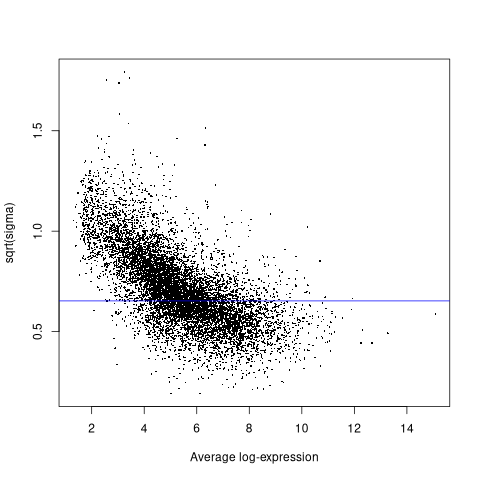

In [83]:
%%R

plotSA(fitmm, xlab = "Average log-expression", ylab = "sqrt(sigma)", zero.weights = FALSE,
       pch = 16, cex = 0.3, col = c("black","red"))

In [84]:
%%R

head(fitmm$design, 5)

                  (Intercept) GroupWM
Ind98-Sample2_WM            1       1
Ind107-Sample1_WM           1       1
Ind117-Sample1_WM           1       1
Ind121-Sample1_WM           1       1
Ind131-Sample1_WM           1       1


In [85]:
%%R

tt_dream <- topTable(fitmm, sort.by = "P", n = Inf)

Removing intercept from test coefficients


In [86]:
%%R
length(which(tt_dream$adj.P.Val < 0.05))

[1] 1935


In [147]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC <= 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 1270
           gene     logFC   AveExpr        t      P.Value    adj.P.Val
HNRNPH3 HNRNPH3 0.6996228  6.265396 4.314869 2.985460e-04 0.0038721035
TMEM94   TMEM94 0.6959521  4.832274 2.913694 8.232149e-03 0.0416677619
ZDHHC14 ZDHHC14 0.6953411  7.965304 3.168226 4.582364e-03 0.0270568610
TAPT1     TAPT1 0.6946985  6.253809 3.324516 3.947148e-03 0.0243897577
MEF2C     MEF2C 0.6941869 11.056604 6.105639 4.409005e-06 0.0001715249
AGL         AGL 0.6934637  5.295023 3.603555 2.231945e-03 0.0159752798
                  B    z.std  gene.1
HNRNPH3  0.03108788 3.616558 HNRNPH3
TMEM94  -3.14180773 2.642397  TMEM94
ZDHHC14 -2.65024504 2.835014 ZDHHC14
TAPT1   -2.32378929 2.882355   TAPT1
MEF2C    4.16501661 4.591107   MEF2C
AGL     -1.71403491 3.057496     AGL


In [148]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream[tt_dream$adj.P.Val < 0.05 & tt_dream$logFC >= -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 926
             gene      logFC  AveExpr         t     P.Value  adj.P.Val
CERS5       CERS5 -0.6988754 5.766458 -3.313180 0.003266032 0.02128690
COL4A3BP COL4A3BP -0.6987421 8.013428 -3.347149 0.003458425 0.02215745
MAPKBP1   MAPKBP1 -0.6939024 5.496292 -3.120799 0.005115557 0.02930585
TMED5       TMED5 -0.6936897 5.428251 -3.046809 0.006069111 0.03325137
HIRA         HIRA -0.6926364 4.898909 -3.219960 0.006293211 0.03422123
NCF2         NCF2 -0.6906217 5.576921 -3.016187 0.006512047 0.03508278
                 B     z.std   gene.1
CERS5    -2.338697 -2.941522    CERS5
COL4A3BP -2.415079 -2.923750 COL4A3BP
MAPKBP1  -2.765369 -2.799666  MAPKBP1
TMED5    -2.939172 -2.744024    TMED5
HIRA     -2.565775 -2.732100     HIRA
NCF2     -2.993804 -2.720819     NCF2


In [89]:
%%R

# Add row names as a new column
tt_dream$gene <- rownames(tt_dream)

In [92]:
%%R
head(tt_dream)

                 gene     logFC  AveExpr         t      P.Value    adj.P.Val
MYO1E           MYO1E -3.663872 9.429126 -15.18508 6.851893e-13 3.117062e-09
IL6ST           IL6ST  2.269453 8.269909  15.18008 6.896154e-13 3.117062e-09
ABCC4           ABCC4  2.112693 9.257283  13.78714 4.456471e-12 1.342883e-08
BLNK             BLNK  1.892693 8.376377  12.96649 1.439085e-11 3.252332e-08
ST6GALNAC3 ST6GALNAC3  3.418599 9.508784  12.25627 4.164442e-11 7.529310e-08
ARHGAP10     ARHGAP10 -6.837440 5.090533 -11.56095 1.302805e-10 1.364180e-07
                  B     z.std     gene.1
MYO1E      19.47887 -7.182359      MYO1E
IL6ST      19.40867  7.181478      IL6ST
ABCC4      17.70702  6.921893      ABCC4
BLNK       16.58454  6.753915       BLNK
ST6GALNAC3 15.54699  6.598106 ST6GALNAC3
ARHGAP10   10.22755 -6.426844   ARHGAP10


In [93]:
%%R

# Optionally reorder or select columns
#tt_dream <- tt_dream[, c("gene", names(tt_dream)[1:8])]

# Write to CSV file
write.table(tt_dream, file = "./files/MG_DvA_WM_v_AL_dream.csv", row.names = FALSE, sep = ",", quote = FALSE)

## Dream with added variables

In [94]:
%%R
colnames(treatments)

[1] "Group"   "Donor"   "Sex"     "Age_cat" "Pmi_cat"


In [95]:
%%R

form <- ~ 0 + Group + Sex + Age_cat + Pmi_cat + (1 | Donor)

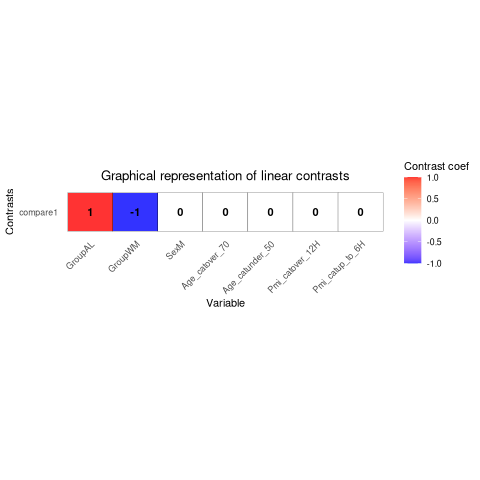

In [96]:
%%R

L <- makeContrastsDream(form, treatments,
  contrasts = c(
    compare1 = "GroupAL - GroupWM"
  )
)

# Visualize contrast matrix
plotContrasts(L)

In [98]:
%%R

vobjDream2 <- voomWithDreamWeights(x2, form, treatments)

In [99]:
%%R

# fit dream model with contrasts
fit_full <- dream(vobjDream2, form, treatments, L)
fit_full <- eBayes(fit_full)

# get names of available coefficients and contrasts for testing
colnames(fit_full)

[1] "compare1"        "GroupAL"         "GroupWM"         "SexM"           
[5] "Age_catover_70"  "Age_catunder_50" "Pmi_catover_12H" "Pmi_catup_to_6H"


In [100]:
%%R

tt_dream_full <- topTable(fit_full, coef="compare1", sort.by = "P", n = Inf)

In [101]:
%%R

length(which(tt_dream_full$adj.P.Val < 0.05))

[1] 2


In [108]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- tt_dream_full[tt_dream_full$adj.P.Val < 0.05 & tt_dream_full$logFC > 0.7, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 2
          logFC  AveExpr        t      P.Value  adj.P.Val        B    z.std
S100A8 5.770220 1.676991 6.267284 1.023684e-05 0.04627054 3.566640 4.412109
CENPB  3.073164 3.426811 7.399043 1.329928e-06 0.01202255 5.367287 4.835228


In [109]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- tt_dream_full[tt_dream_full$adj.P.Val < 0.05 & tt_dream_full$logFC < -0.7, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 0
[1] logFC     AveExpr   t         P.Value   adj.P.Val B         z.std    
<0 rows> (or 0-length row.names)


### Variance partition plots

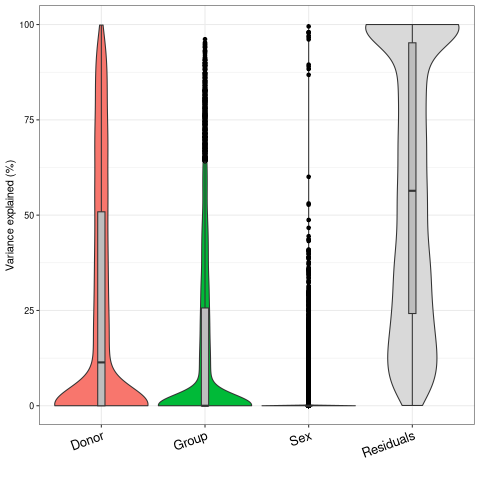

In [104]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

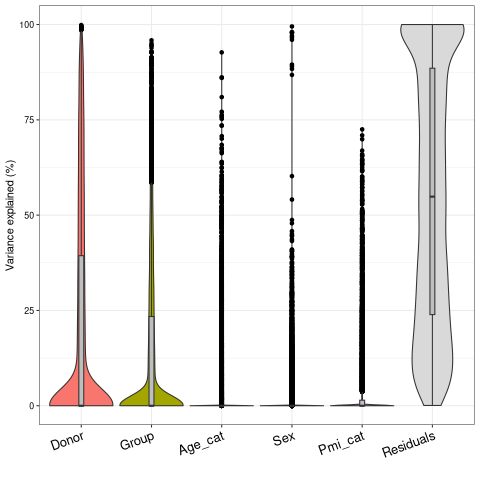

In [105]:
%%R

form <- ~ (1 | Group) + (1 | Sex) + (1 | Age_cat) + (1 | Pmi_cat) + (1 | Donor)
vp <- fitExtractVarPartModel(y2, form, treatments)

plotVarPart(sortCols(vp))

Removing intercept from test coefficients


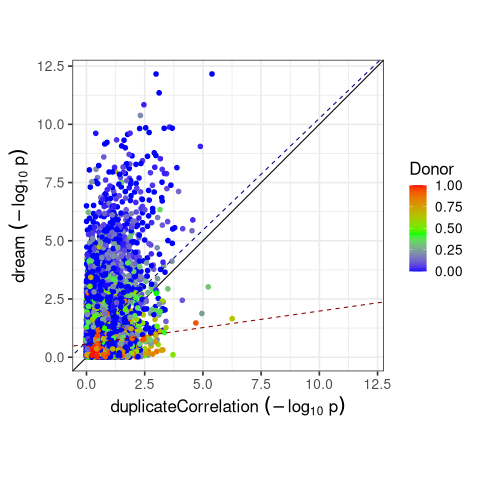

In [107]:
%%R

# Compare p-values and make plot
p1 <- topTable(tmp2, coef = "GroupAL - GroupWM", number = Inf, sort.by = "none")$P.Value
p2 <- topTable(fitmm, number = Inf, sort.by = "none")$P.Value

plotCompareP(p1, p2, vp$Donor, corfit2$consensus)

# Box plots of highly differentially expressed genes

In [110]:
%%R
#X2 is the norm lib sizes and trimmed
cpm <- edgeR::cpm(x2, log=FALSE, prior.counts=3)
lcpm <- edgeR::cpm(x2, log=TRUE, prior.count=3)

In [111]:
%%R
library(reshape2)  # For transforming data from wide to long format
library(ggplot2)   # For plotting

# Step 1: Combine Expression and Treatment Data
# Convert the E matrix into a dataframe
expr_df <- as.data.frame(cpm)
expr_df$gene <- rownames(cpm)  # Add gene names as a column

head(expr_df)

           Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM
AL627309.1         7.732139          17.84787          6.577877
AL669831.5        23.196418          59.49289         38.527568
NOC2L             15.464279          17.84787         22.552723
ISG15              0.000000           0.00000          1.879394
C1orf159          30.928558          52.05628         29.130600
SDF4              27.062488          26.77180         32.889387
           Ind121-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM
AL627309.1          6.759544         3.5860910         12.012886
AL669831.5         33.797721        20.6200232         12.012886
NOC2L              16.898860        25.1026370         12.012886
ISG15               6.759544         0.8965227          6.006443
C1orf159           23.658405        11.6547957         24.025771
SDF4               13.519088        28.6887280         30.032214
           Ind139-Sample1_WM Ind140-Sample1_WM Ind145-Sample1_WM
AL627309.1         10.078992    

In [112]:
%%R
colnames(expr_df)

 [1] "Ind98-Sample2_WM"  "Ind107-Sample1_WM" "Ind117-Sample1_WM"
 [4] "Ind121-Sample1_WM" "Ind131-Sample1_WM" "Ind133-Sample1_WM"
 [7] "Ind139-Sample1_WM" "Ind140-Sample1_WM" "Ind145-Sample1_WM"
[10] "Ind113-Sample2_AL" "Ind114-Sample1_AL" "Ind114-Sample2_AL"
[13] "Ind115-Sample1_AL" "Ind115-Sample2_AL" "Ind122-Sample1_AL"
[16] "Ind127-Sample3_AL" "Ind127-Sample4_AL" "Ind130-Sample1_AL"
[19] "Ind130-Sample2_AL" "Ind143-Sample1_AL" "gene"             


In [113]:
%%R
# Drop the "gene" column
expr_df <- expr_df[, !colnames(expr_df) %in% "gene"]

# Display the modified dataframe
head(expr_df)

           Ind98-Sample2_WM Ind107-Sample1_WM Ind117-Sample1_WM
AL627309.1         7.732139          17.84787          6.577877
AL669831.5        23.196418          59.49289         38.527568
NOC2L             15.464279          17.84787         22.552723
ISG15              0.000000           0.00000          1.879394
C1orf159          30.928558          52.05628         29.130600
SDF4              27.062488          26.77180         32.889387
           Ind121-Sample1_WM Ind131-Sample1_WM Ind133-Sample1_WM
AL627309.1          6.759544         3.5860910         12.012886
AL669831.5         33.797721        20.6200232         12.012886
NOC2L              16.898860        25.1026370         12.012886
ISG15               6.759544         0.8965227          6.006443
C1orf159           23.658405        11.6547957         24.025771
SDF4               13.519088        28.6887280         30.032214
           Ind139-Sample1_WM Ind140-Sample1_WM Ind145-Sample1_WM
AL627309.1         10.078992    

In [114]:
%%R

# Convert design matrix to a dataframe and add sample IDs as rownames
design_df <- as.data.frame(y_vqw_full$design)
design_df$sample <- rownames(design_df)
design_df

                  GroupAL GroupWM SexM Age_catover_70 Age_catunder_50
Ind98-Sample2_WM        0       1    1              0               1
Ind107-Sample1_WM       0       1    1              0               1
Ind117-Sample1_WM       0       1    0              0               1
Ind121-Sample1_WM       0       1    0              0               1
Ind131-Sample1_WM       0       1    1              0               0
Ind133-Sample1_WM       0       1    1              1               0
Ind139-Sample1_WM       0       1    1              1               0
Ind140-Sample1_WM       0       1    0              1               0
Ind145-Sample1_WM       0       1    0              1               0
Ind113-Sample2_AL       1       0    0              1               0
Ind114-Sample1_AL       1       0    0              0               1
Ind114-Sample2_AL       1       0    0              0               1
Ind115-Sample1_AL       1       0    1              0               1
Ind115-Sample2_AL   

In [115]:
%%R

# Step 1: Rename the columns of expr_df to match the design information
colnames(expr_df) <- paste0("Sample", seq_len(ncol(expr_df) - 1))  # Adjust for gene column
expr_df$gene <- rownames(expr_df)

# Update design_df to have corresponding sample IDs
design_df$sample <- paste0("Sample", seq_len(nrow(design_df)))

# Step 2: Melt the expression data into a long format
expr_long <- melt(expr_df, id.vars = "gene", variable.name = "sample", value.name = "expression")

# Step 3: Merge expression data with treatment information
expr_treatment <- merge(expr_long, design_df, by = "sample")

In [116]:
%%R
head(expr_treatment)

   sample     gene expression GroupAL GroupWM SexM Age_catover_70
1 Sample1      AK3   27.06249       0       1    1              0
2 Sample1     RCL1   65.72318       0       1    1              0
3 Sample1     JAK2  487.12478       0       1    1              0
4 Sample1   PLGRKT   23.19642       0       1    1              0
5 Sample1    CD274   38.66070       0       1    1              0
6 Sample1 PDCD1LG2   23.19642       0       1    1              0
  Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H
1               1               1               0
2               1               1               0
3               1               1               0
4               1               1               0
5               1               1               0
6               1               1               0


In [150]:
%%R

# Define the gene of interest
gene_of_interest <- "SPP1"  # Replace with the actual gene name

# Subset the dataframe to get the row corresponding to the gene
gene_info <- subset(tt_dream, gene == gene_of_interest)

# Print the gene information
print(gene_info)

     gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
SPP1 SPP1 -2.180643 11.93158 -6.782775 3.718945e-06 0.0001528148 2.294629
         z.std gene.1
SPP1 -4.626501   SPP1


In [152]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "FAM135B")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")
head(gene_data)

        sample    gene  expression GroupAL GroupWM SexM Age_catover_70
768    Sample1 FAM135B    3.866070       0       1    1              0
10904 Sample10 FAM135B  206.126195       1       0    0              1
23223 Sample11 FAM135B 2312.984340       1       0    0              0
32263 Sample12 FAM135B 1263.399620       1       0    0              0
41304 Sample13 FAM135B    0.000000       1       0    1              0
45968 Sample14 FAM135B    4.556918       1       0    1              0
      Age_catunder_50 Pmi_catover_12H Pmi_catup_to_6H treatment
768                 1               1               0        WM
10904               0               0               1        AL
23223               1               0               0        AL
32263               1               0               0        AL
41304               1               0               0        AL
45968               1               0               0        AL


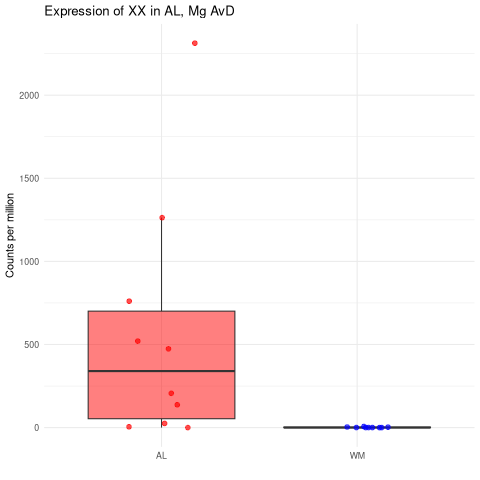

In [153]:
%%R
ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of XX in AL, Mg AvD",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

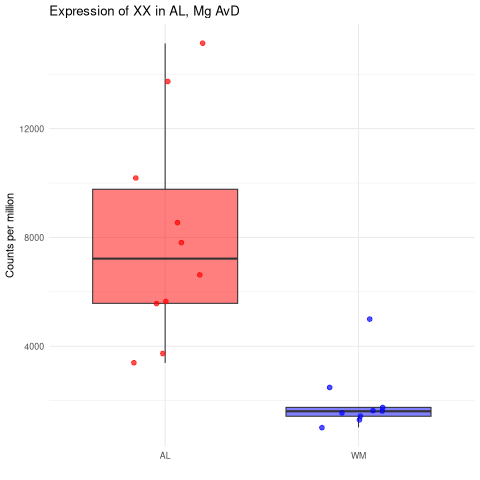

In [154]:
%%R
# Subset data for the specified gene
gene_data <- subset(expr_treatment, gene == "SPP1")
gene_data$treatment <- ifelse(gene_data$GroupWM == 1, "WM", "AL")

ggplot(gene_data, aes(x = treatment, y = expression, fill = treatment)) +
  geom_boxplot(alpha = 0.5, outlier.shape = NA) +  # Boxplots without outliers
  geom_jitter(width = 0.2, alpha = 0.7, size = 2, aes(color = treatment)) +  # Individual points
  scale_fill_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for boxes
  scale_color_manual(values = c("WM" = "blue", "AL" = "red")) +  # Custom colors for points
  labs(
    title = "Expression of XX in AL, Mg AvD",
    x = "",
    y = "Counts per million"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Try to plot some genes to see if you belive results

In [124]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm, colors
#from gprofiler import gprofiler

In [125]:
from matplotlib import rcParams
from matplotlib import cm, colors

# Create a custom color map using 'PuRd' color map
colors2 = plt.cm.PuRd(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7, 0.8, 20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [126]:
#Define a nice colour map for gene expression
colors2 = plt.cm.plasma(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap2 = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [127]:
plt.rcParams['figure.figsize']=(5,5) #rescale figures
sc.settings.verbosity = 3
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=300,transparent=True, fontsize=12) #color_map=mymap2)
sc.settings.figdir = '/afs/crc.nd.edu/user/e/eaboelno/sysVI_analysis/Human_scVI_single/figures_MG/'
sc.logging.print_header()

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [128]:
adata= sc.read_h5ad('/scratch365/eaboelno/BACKUP_h5ad_IMPORTANT/scVI_mdata_MG_working.h5ad')
adata

AnnData object with n_obs × n_vars = 37619 × 29040
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'S_score', 'G2M_score', 'Cycling cells', 'Cycling_cells', 'Microglia', 'DAM', 'Macrophages', 'BAM', 'Monocytes', 'DCs

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_lesion_type']`


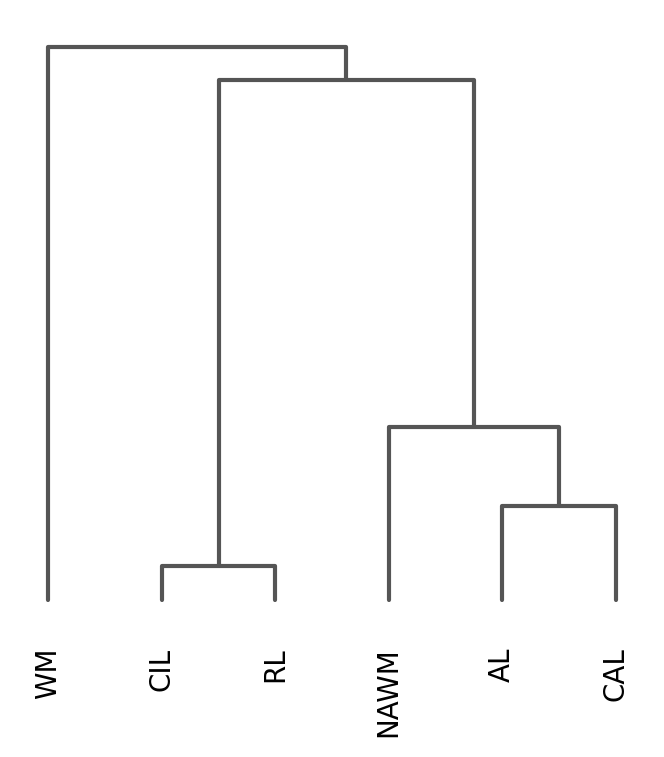

<Axes: >

In [129]:
sc.tl.dendrogram(adata, 'lesion_type')
sc.pl.dendrogram(adata, 'lesion_type')

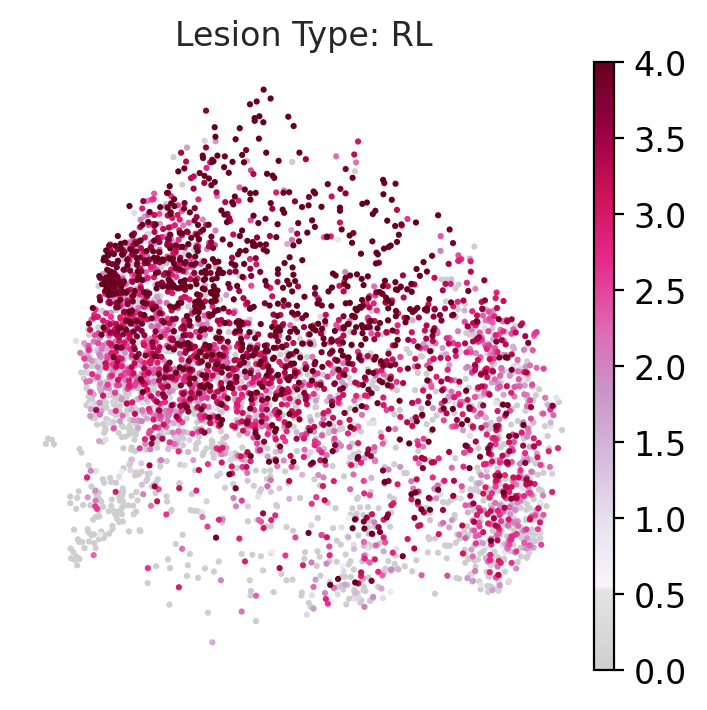

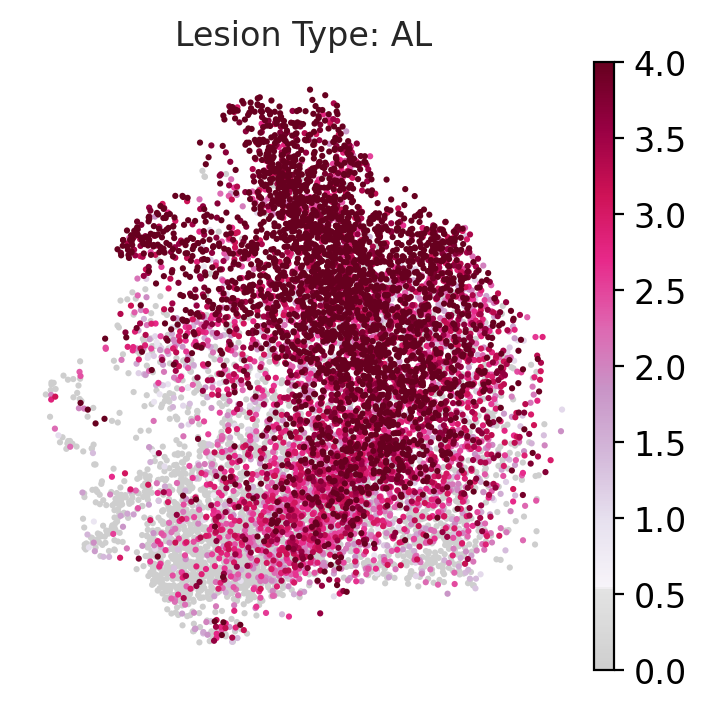

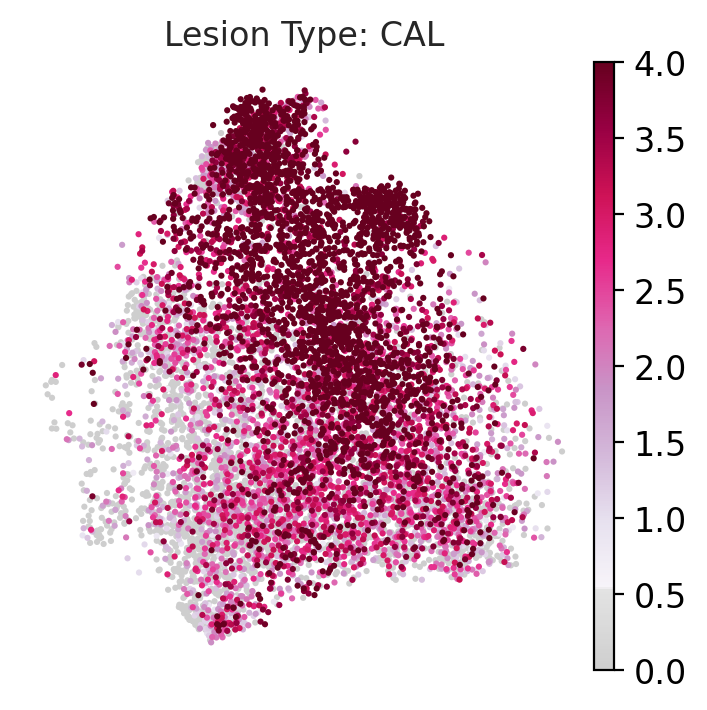

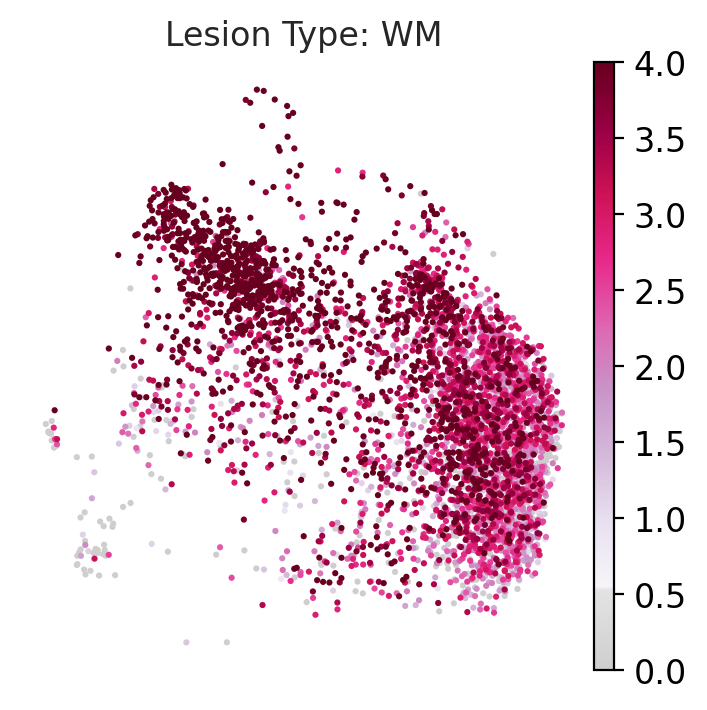

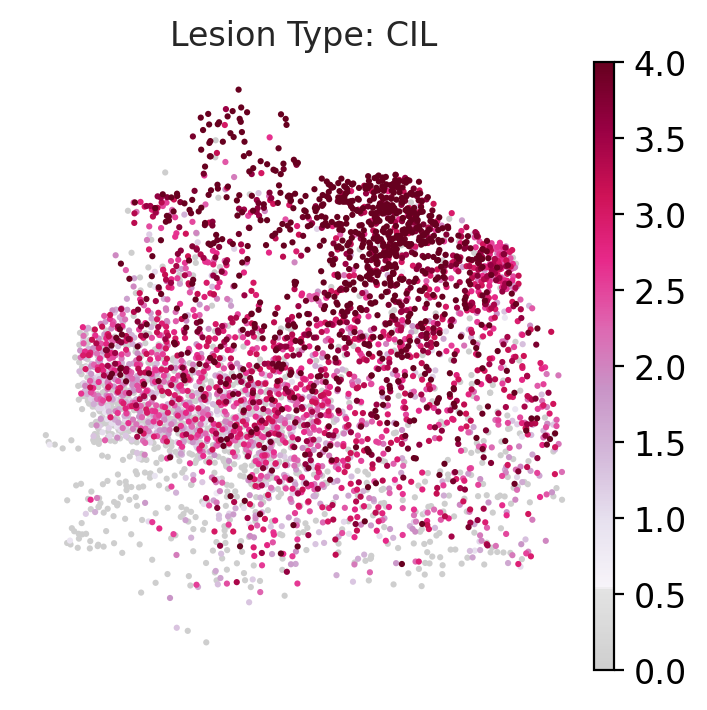

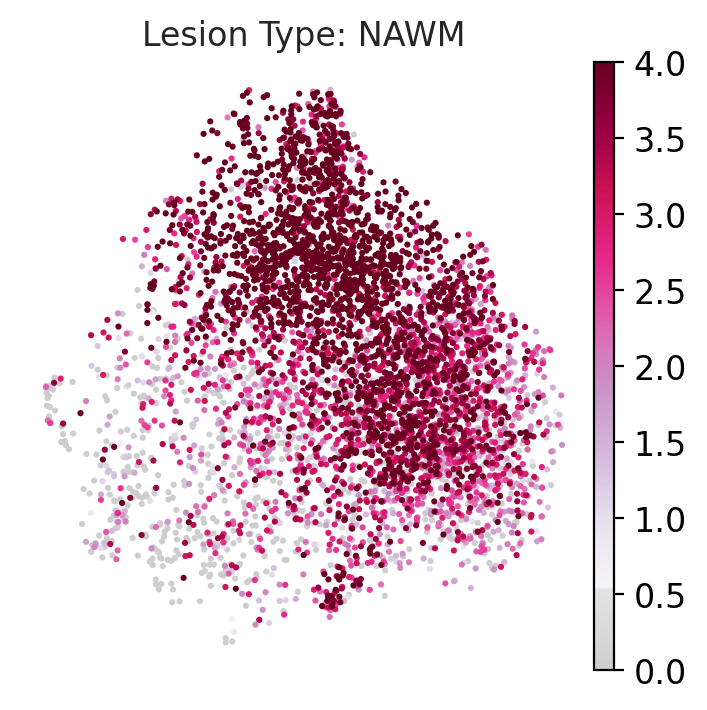

In [130]:
# Specify the gene name you want to include in the filename
gene_name = 'SPP1'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

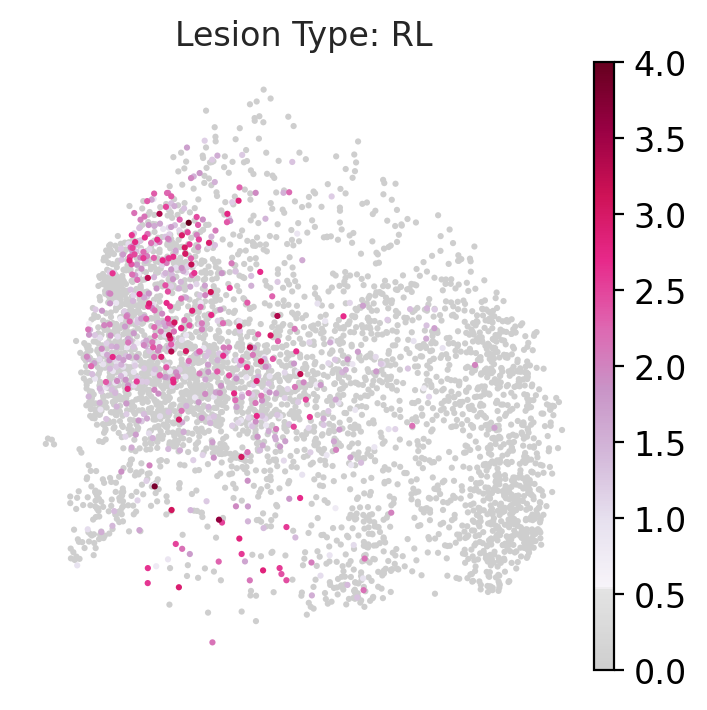

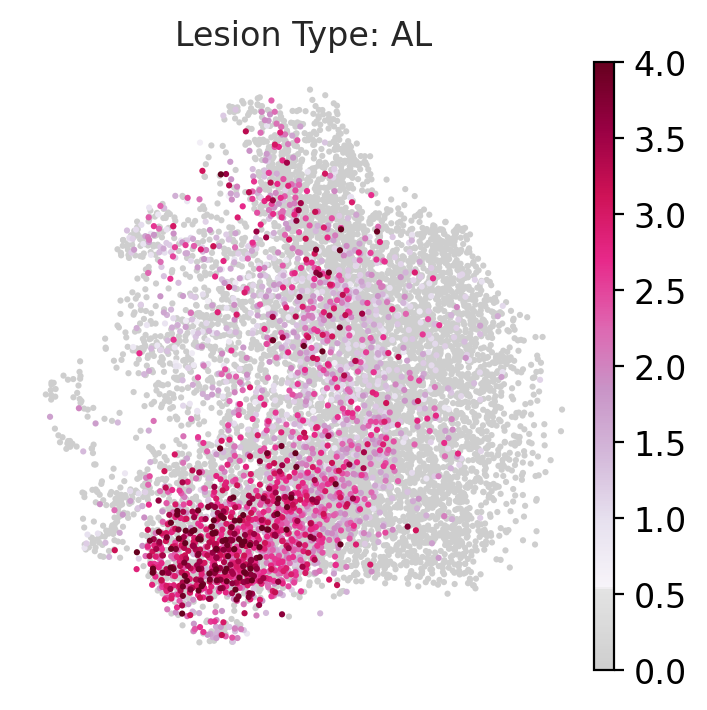

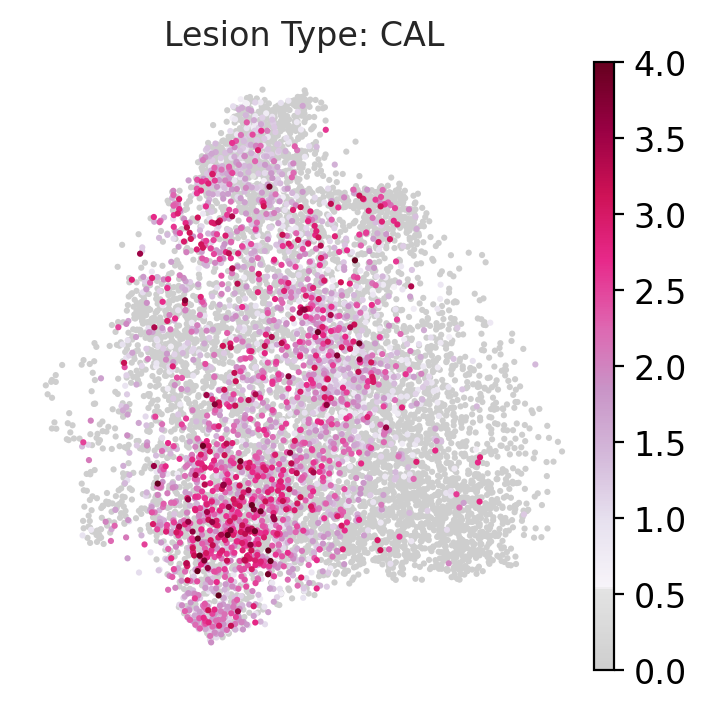

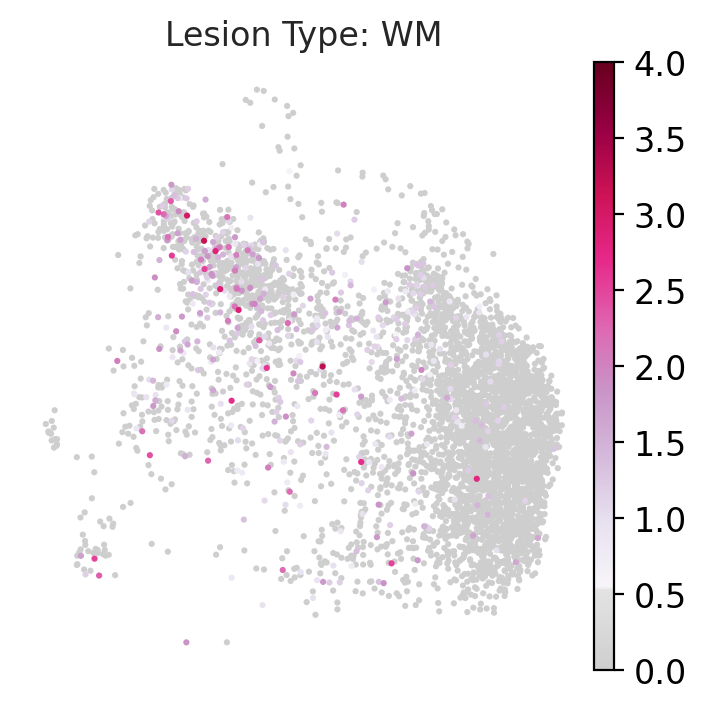

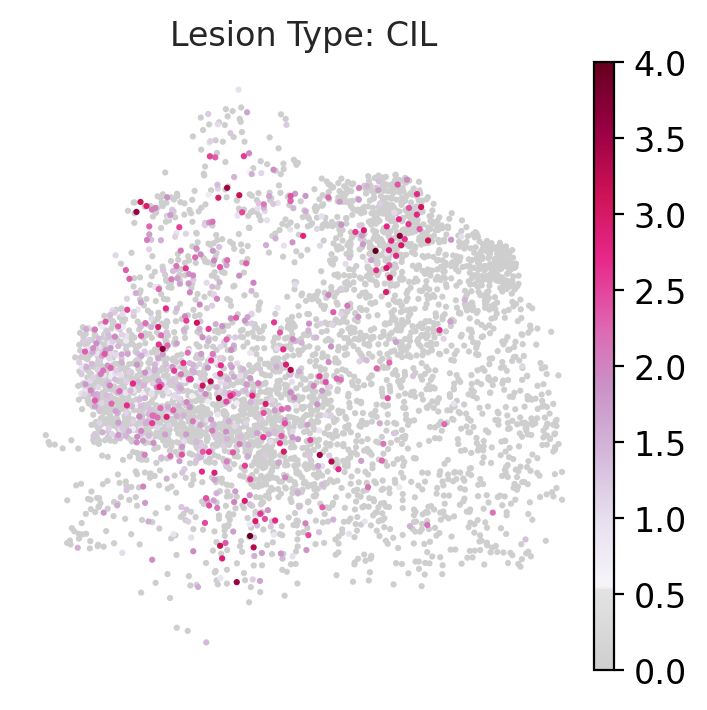

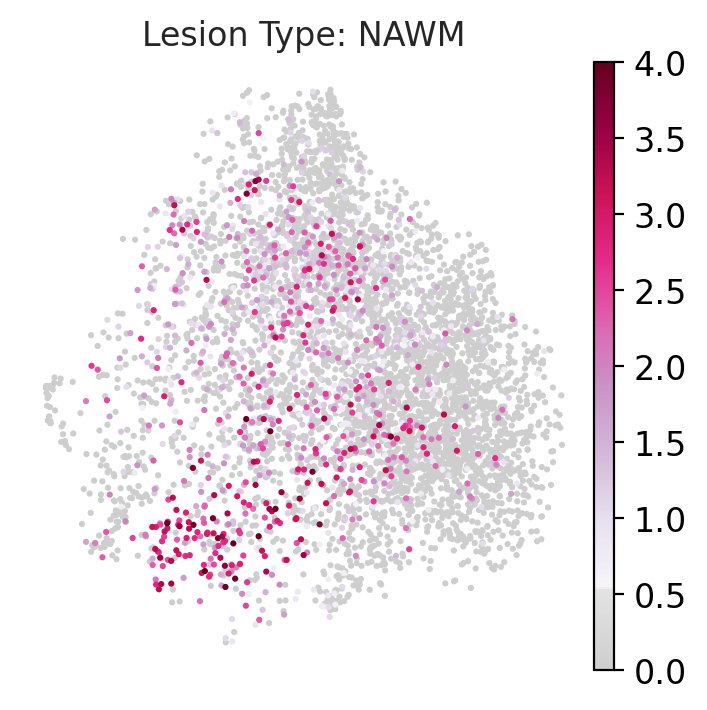

In [155]:
# Specify the gene name you want to include in the filename
gene_name = 'NUPR1'  # You can change this to any gene name you wish to use

# Loop through each unique value in 'lesion_status'
for lesion_type in set(adata.obs['lesion_type']):
    # Subset the data to only include the current lesion type
    adata_subset = adata[adata.obs['lesion_type'] == lesion_type]
    
    # Generate the UMAP plot for the current subset
    sc.pl.embedding(
        adata_subset, 
        basis='X_umap', 
        color=gene_name,  # Use the gene name
        layer='log1p_norm',
        color_map=mymap, 
        legend_fontweight='normal', 
        s=20, 
        frameon=False,
        vmax=4,
        title=f"Lesion Type: {lesion_type}",
        #save=f'_{gene_name}_lesion_status_{lesion_type}.png'  # Save with gene name and lesion type
    )
    
    # Show the plot
    plt.show()

# Do results overlap with LR pairs?

In [131]:
import liana as li

In [132]:
lr_pairs = li.resource.select_resource('consensus')
lr_pairs.head()

ligand receptor
0  LGALS9    PTPRC
1  LGALS9      MET
2  LGALS9     CD44
3  LGALS9     LRP1
4  LGALS9     CD47

In [133]:
%R -o tt_dream

In [134]:
# Display the first few rows
tt_dream.head()

gene     logFC   AveExpr          t       P.Value  \
MYO1E            MYO1E -3.663872  9.429126 -15.185077  6.851893e-13   
IL6ST            IL6ST  2.269453  8.269909  15.180076  6.896154e-13   
ABCC4            ABCC4  2.112693  9.257283  13.787137  4.456471e-12   
BLNK              BLNK  1.892693  8.376377  12.966488  1.439085e-11   
ST6GALNAC3  ST6GALNAC3  3.418599  9.508784  12.256273  4.164442e-11   

               adj.P.Val          B     z.std      gene.1  
MYO1E       3.117062e-09  19.478874 -7.182359       MYO1E  
IL6ST       3.117062e-09  19.408673  7.181478       IL6ST  
ABCC4       1.342883e-08  17.707020  6.921893       ABCC4  
BLNK        3.252332e-08  16.584543  6.753915        BLNK  
ST6GALNAC3  7.529310e-08  15.546988  6.598106  ST6GALNAC3

In [135]:
tt_dream.rename(columns={'adj.P.Val': 'Padj'}, inplace=True)
tt_dream.rename(columns={'P.Value': 'Pvalue'}, inplace=True)

In [136]:
# Move row names to a column called 'gene'
tt_dream['gene'] = tt_dream.index

# Reset the index so the gene names become part of the dataframe
tt_dream.reset_index(drop=True, inplace=True)

# Display the updated dataframe
tt_dream.head()

gene     logFC   AveExpr          t        Pvalue          Padj  \
0       MYO1E -3.663872  9.429126 -15.185077  6.851893e-13  3.117062e-09   
1       IL6ST  2.269453  8.269909  15.180076  6.896154e-13  3.117062e-09   
2       ABCC4  2.112693  9.257283  13.787137  4.456471e-12  1.342883e-08   
3        BLNK  1.892693  8.376377  12.966488  1.439085e-11  3.252332e-08   
4  ST6GALNAC3  3.418599  9.508784  12.256273  4.164442e-11  7.529310e-08   

           B     z.std      gene.1  
0  19.478874 -7.182359       MYO1E  
1  19.408673  7.181478       IL6ST  
2  17.707020  6.921893       ABCC4  
3  16.584543  6.753915        BLNK  
4  15.546988  6.598106  ST6GALNAC3

In [137]:
sigs = tt_dream[(tt_dream.Padj < 0.05) & (abs(tt_dream.logFC) >= 1)]
sigs.shape

(1270, 9)

In [138]:
lr_pairs.shape

(4624, 2)

In [139]:
sigs.head()

gene     logFC   AveExpr          t        Pvalue          Padj  \
0       MYO1E -3.663872  9.429126 -15.185077  6.851893e-13  3.117062e-09   
1       IL6ST  2.269453  8.269909  15.180076  6.896154e-13  3.117062e-09   
2       ABCC4  2.112693  9.257283  13.787137  4.456471e-12  1.342883e-08   
3        BLNK  1.892693  8.376377  12.966488  1.439085e-11  3.252332e-08   
4  ST6GALNAC3  3.418599  9.508784  12.256273  4.164442e-11  7.529310e-08   

           B     z.std      gene.1  
0  19.478874 -7.182359       MYO1E  
1  19.408673  7.181478       IL6ST  
2  17.707020  6.921893       ABCC4  
3  16.584543  6.753915        BLNK  
4  15.546988  6.598106  ST6GALNAC3

In [140]:
ligands = lr_pairs['ligand'].unique()
receptors = lr_pairs['receptor'].unique()

# Combining both ligands and receptors and keeping only unique values
unique_genes = set(ligands).union(set(receptors))

# Checking for overlap with 'sigs' dataframe on the 'gene' column
overlap_genes = sigs[sigs['gene'].isin(unique_genes)]
overlap_genes

gene     logFC   AveExpr          t        Pvalue          Padj  \
7      ABCA1 -2.871830  7.456305 -11.455642  1.461815e-10  1.364180e-07   
16      CD44 -4.611762  4.743871 -10.602523  5.992990e-10  3.186860e-07   
19       LPL -6.305634  5.514095 -10.375745  8.875418e-10  4.011689e-07   
37     MELTF -4.551077  3.315598  -9.220564  7.021795e-09  1.670448e-06   
41     PTPRG -5.951461  8.030467  -9.448931  8.598751e-09  1.850779e-06   
...      ...       ...       ...        ...           ...           ...   
1714   TGFB2 -1.496203  2.272053  -2.985069  6.993955e-03  3.684658e-02   
1743   CSF1R  1.084624  9.038279   3.091266  7.366485e-03  3.818407e-02   
1832    VASP -1.282370  5.871403  -2.972794  8.964972e-03  4.421350e-02   
1866     FN1 -1.778124  2.290422  -2.888894  9.529895e-03  4.611921e-02   
1886  LRRC4C -3.935637  4.785154  -2.975821  9.913551e-03  4.749258e-02   

              B     z.std  gene.1  
7     14.371910 -6.409308   ABCA1  
16    12.945107 -6.190615    CD44  
19     9.425658 -6.128423     LPL  
37    10.579179 -5.790402   MELTF  
41     7.189638 -5.756280   PTPRG  
...         ...       ...     ...  
1714  -3.079421 -2.697132   TGFB2  
1743  -2.823014  2.679806   CSF1R  
1832  -2.914079 -2.613387    VASP  
1866  -3.207907 -2.592436     FN1  
1886  -2.889897 -2.578830  LRRC4C  

[146 rows x 9 columns]

In [141]:
# Checking the direction of logFC for the overlapping genes
overlap_genes_direction = overlap_genes[['gene', 'logFC']].copy()

# Determine the direction of logFC
overlap_genes_direction['logFC_direction'] = overlap_genes_direction['logFC'].apply(lambda x: 'positive' if x > 0 else 'negative')

# Displaying the results
overlap_genes_direction

gene     logFC logFC_direction
7      ABCA1 -2.871830        negative
16      CD44 -4.611762        negative
19       LPL -6.305634        negative
37     MELTF -4.551077        negative
41     PTPRG -5.951461        negative
...      ...       ...             ...
1714   TGFB2 -1.496203        negative
1743   CSF1R  1.084624        positive
1832    VASP -1.282370        negative
1866     FN1 -1.778124        negative
1886  LRRC4C -3.935637        negative

[146 rows x 3 columns]

In [142]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 42


ligand   receptor  logFC_ligand  logFC_receptor
17     IGF1      IGF2R      1.769812       -1.781509
26     IL16        CD9      1.672854       -2.824171
6    ADAM28      ITGA4      1.620516       -3.342364
0    LGALS9       CD44     -1.098763       -4.611762
1    LGALS9    COLEC12     -1.098763       -5.464393
38     PSAP     CELSR1     -1.127502       -2.994018
36      PKM       CD44     -1.689205       -4.611762
8       FN1  TNFRSF11B     -1.778124       -2.771957
9       FN1       CD44     -1.778124       -4.611762
37      FN1       DPP4     -1.778124       -3.236502
12      FN1      PLAUR     -1.778124       -3.394943
10      FN1      C5AR1     -1.778124       -1.717371
11      FN1       SDC2     -1.778124       -4.767935
16     APOE       SDC2     -1.783447       -4.767935
27     APOE      SORL1     -1.783447        1.171383
34     APOE      ABCA1     -1.783447       -2.871830
40  RARRES1       NRP2     -1.856399       -1.154674
5     ALCAM        CD6     -1.984311       -2.252240
4     ALCAM       NRP1     -1.984311       -2.260724
19     SPP1     PTGER4     -2.180643       -2.952036
18     SPP1       CD44     -2.180643       -4.611762
14    OLFM2      ROBO2     -2.219309       -3.197628
15     IL1B      ADRB2     -2.303302        1.322535
30    F13A1      ITGB1     -2.482631       -1.088121
29    F13A1      ITGA4     -2.482631       -3.342364
32     PLTP      ABCA1     -3.132025       -2.871830
2    ADAM12      ITGB1     -3.166385       -1.088121
20    VEGFA       NRP1     -3.188616       -2.260724
21    VEGFA       NRP2     -3.188616       -1.154674
39    VEGFA       CD44     -3.188616       -4.611762
22    VEGFA      ITGB1     -3.188616       -1.088121
23    VEGFA      SIRPA     -3.188616       -1.206292
41     CSF1     CSF2RA     -3.359146        1.155382
3      CSF1      SIRPA     -3.359146       -1.206292
25   CXCL10       DPP4     -3.455787       -3.236502
7    COL4A1       CD44     -3.470111       -4.611762
13   COL4A2       CD44     -3.740766       -4.611762
33      VIM       CD44     -3.751677       -4.611762
24    HBEGF       CD44     -3.910511       -4.611762
28    HBEGF        CD9     -3.910511       -2.824171
31    HBEGF       CD82     -3.910511       -1.750241
35      LPL       CD44     -6.305634       -4.611762

In [145]:
sigs_up = tt_dream[(tt_dream.Padj < 0.05) & (tt_dream.logFC <= 1)]
sigs_up.shape

(1511, 9)

In [146]:
# Step 1: Convert ligands and receptors to a list
ligands = lr_pairs['ligand'].tolist()
receptors = lr_pairs['receptor'].tolist()

# Step 2: Filter DEGs from 'sigs'
degs = set(sigs_up['gene'])  # Create a set for faster lookup

# Step 3: Check which ligand-receptor pairs have both ligands and receptors as DEGs
matched_pairs = lr_pairs[(lr_pairs['ligand'].isin(degs)) & (lr_pairs['receptor'].isin(degs))]

# Step 4: Count the matched pairs
num_matched_pairs = matched_pairs.shape[0]

# Output the result
print(f'Total ligand-receptor pairs where both are differentially expressed: {num_matched_pairs}')

# Step 5: Optional - view the matched pairs with direction of change
matched_pairs_with_logFC = matched_pairs.merge(sigs[['gene', 'logFC']], left_on='ligand', right_on='gene', how='left')\
                                        .merge(sigs[['gene', 'logFC']], left_on='receptor', right_on='gene', how='left', suffixes=('_ligand', '_receptor'))

# Sorting the table by 'logFC_ligand' in descending order
sorted_table = matched_pairs_with_logFC.sort_values(by='logFC_ligand', ascending=False)

# Displaying the sorted table with the selected columns
sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']]

Total ligand-receptor pairs where both are differentially expressed: 50


ligand   receptor  logFC_ligand  logFC_receptor
0    LGALS9      PTPRC     -1.098763             NaN
1    LGALS9       CD44     -1.098763       -4.611762
2    LGALS9       LRP1     -1.098763             NaN
3    LGALS9    COLEC12     -1.098763       -5.464393
46     PSAP     CELSR1     -1.127502       -2.994018
33     PSAP       LRP1     -1.127502             NaN
45    GSTO1       RYR1     -1.507873             NaN
43      PKM       CD44     -1.689205       -4.611762
14      FN1      PLAUR     -1.778124       -3.394943
11      FN1       CD44     -1.778124       -4.611762
12      FN1      C5AR1     -1.778124       -1.717371
10      FN1  TNFRSF11B     -1.778124       -2.771957
13      FN1       SDC2     -1.778124       -4.767935
44      FN1       DPP4     -1.778124       -3.236502
36     APOE      ABCA1     -1.783447       -2.871830
18     APOE       LRP1     -1.783447             NaN
17     APOE       SDC2     -1.783447       -4.767935
48  RARRES1       NRP2     -1.856399       -1.154674
8     ALCAM        CD6     -1.984311       -2.252240
7     ALCAM       NRP1     -1.984311       -2.260724
20     SPP1     PTGER4     -2.180643       -2.952036
19     SPP1       CD44     -2.180643       -4.611762
16    OLFM2      ROBO2     -2.219309       -3.197628
29    F13A1      ITGA4     -2.482631       -3.342364
30    F13A1      ITGB1     -2.482631       -1.088121
34     PLTP      ABCA1     -3.132025       -2.871830
5    ADAM12      ITGB1     -3.166385       -1.088121
21    VEGFA       NRP1     -3.188616       -2.260724
47    VEGFA       CD44     -3.188616       -4.611762
23    VEGFA      ITGB1     -3.188616       -1.088121
24    VEGFA      ITGAV     -3.188616             NaN
22    VEGFA       NRP2     -3.188616       -1.154674
25    VEGFA      SIRPA     -3.188616       -1.206292
49     CSF1      CSF3R     -3.359146             NaN
6      CSF1      SIRPA     -3.359146       -1.206292
27   CXCL10       DPP4     -3.455787       -3.236502
9    COL4A1       CD44     -3.470111       -4.611762
15   COL4A2       CD44     -3.740766       -4.611762
35      VIM       CD44     -3.751677       -4.611762
28    HBEGF        CD9     -3.910511       -2.824171
26    HBEGF       CD44     -3.910511       -4.611762
31    HBEGF       CD82     -3.910511       -1.750241
41    FABP5       RXRA     -4.266962             NaN
32      LPL       LRP1     -6.305634             NaN
42      LPL       CD44     -6.305634       -4.611762
4    ADAM10       CD44           NaN       -4.611762
37   ADAM10      GPNMB           NaN       -4.002144
38   ADAM10      CADM1           NaN       -4.527988
39    FARP2     PLXNA3           NaN             NaN
40    FARP2     PLXNA1           NaN       -1.857395

In [ ]:
#sorted_table[['ligand', 'receptor', 'logFC_ligand', 'logFC_receptor']].to_csv('./files/LR_pairs_MG_active_AL_CAL_DESIGN_NEW.csv', sep='\t', index=False)